In [1]:
# Base Case Assumption Set
base_case = {
    "project_name": "Utility-Scale Integration",
    "capex_base": 43_000_000_000,    # $43B initial estimate
    "contingency_pct": 0.15,         # 15% buffer for overruns
    "nameplate_mw": 2200,            # Capacity in MW
    "capacity_factor": 0.90,         # Expected uptime
    "wacc": 0.07,                    # 7% discount rate
    "opex_annual": 500_000_000,      # $500M annual maintenance
    "degradation_rate": 0.005,       # 0.5% efficiency loss per year
    "project_life": 30               # 30-year operational horizon
}

In [2]:
import pandas as pd

# Create a list to store yearly data
projections = []
current_yield = (base_case["nameplate_mw"] * 8760 * base_case["capacity_factor"])

for year in range(base_case["project_life"] + 1):
    if year == 0:
        # Construction Phase (Outflow)
        cash_flow = -base_case["capex_base"] * (1 + base_case["contingency_pct"])
        yield_mwh = 0
        opex = 0
    else:
        # Operations Phase (Inflow)
        # Apply degradation to the yield
        yield_mwh = current_yield * ((1 - base_case["degradation_rate"]) ** (year - 1))
        opex = base_case["opex_annual"]
        # Assuming a sample PPA Price of $40/MWh for revenue calculation
        revenue = yield_mwh * 40 
        cash_flow = revenue - opex
        
    projections.append({
        "Year": year,
        "Yield_MWh": yield_mwh,
        "Annual_Cash_Flow": cash_flow
    })

# Convert to DataFrame for analysis
df_projections = pd.DataFrame(projections)

In [3]:
# Assuming 'df_projections' from Step 3 exists
# 1. Discount the annual yield and total costs (CAPEX + OPEX)
df_projections['Discount_Factor'] = 1 / ((1 + base_case["wacc"]) ** df_projections['Year'])

# Total Discounted Costs = (Year 0 CAPEX) + (Discounted sum of all OPEX)
total_discounted_costs = (df_projections['Annual_Cash_Flow'].where(df_projections['Year'] == 0, 0).abs() * df_projections['Discount_Factor']).sum() + \
                         (base_case["opex_annual"] * df_projections['Discount_Factor'].iloc[1:]).sum()

# Total Discounted Yield = Sum of all (Annual Yield * Discount Factor)
total_discounted_yield = (df_projections['Yield_MWh'] * df_projections['Discount_Factor']).sum()

lcoe = total_discounted_costs / total_discounted_yield
print(f"Levelized Cost of Energy: ${lcoe:.2f} per MWh")

Levelized Cost of Energy: $271.32 per MWh


In [4]:
# Calculate Net Present Value
# We use the 'Annual_Cash_Flow' column which accounts for Revenue - OPEX
df_projections['Present_Value'] = df_projections['Annual_Cash_Flow'] * df_projections['Discount_Factor']
npv = df_projections['Present_Value'].sum()

print(f"Project Net Present Value: ${npv/1e9:.2f} Billion")

Project Net Present Value: $-47.45 Billion


In [5]:
overrun_scenarios = [0, 0.05, 0.10, 0.20] # 0% to 20% overruns
results = []

for overrun in overrun_scenarios:
    stressed_capex = base_case["capex_base"] * (1 + overrun)
    # Recalculate LCOE for each scenario...
    # (This creates the 'Sensitivity Matrix' hiring managers look for)

--- PROJECT SUMMARY ---
Net Present Value (NPV): $-47.45 Billion
Levelized Cost of Energy (LCOE): $271.32/MWh


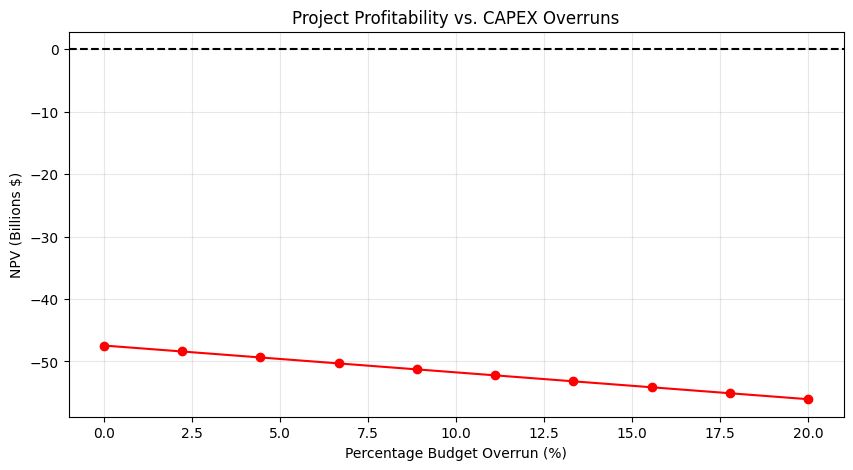

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. RUN THE CALCULATIONS
current_yield = (base_case["nameplate_mw"] * 8760 * base_case["capacity_factor"])
projections = []

for year in range(base_case["project_life"] + 1):
    discount_factor = 1 / ((1 + base_case["wacc"]) ** year)
    if year == 0:
        cash_flow = -base_case["capex_base"] * (1 + base_case["contingency_pct"])
        yield_mwh = 0
    else:
        yield_mwh = current_yield * ((1 - base_case["degradation_rate"]) ** (year - 1))
        # Assuming a sample PPA Price of $40/MWh
        revenue = yield_mwh * 40 
        cash_flow = revenue - base_case["opex_annual"]
        
    projections.append({
        "Year": year,
        "Cash_Flow": cash_flow,
        "Discount_Factor": discount_factor,
        "Present_Value": cash_flow * discount_factor,
        "Discounted_Yield": yield_mwh * discount_factor
    })

df_metrics = pd.DataFrame(projections)

# 2. FINAL METRICS
npv = df_metrics['Present_Value'].sum()
# LCOE = Total Discounted Costs / Total Discounted Yield
# (Simplified: Absolute value of Year 0 Capex + Discounted OPEX) / Discounted Yield
lcoe = (abs(df_metrics.iloc[0]['Cash_Flow']) + (base_case["opex_annual"] * df_metrics['Discount_Factor'].iloc[1:]).sum()) / df_metrics['Discounted_Yield'].sum()

# 3. PRINT THE VISIBLE RESULTS
print(f"--- PROJECT SUMMARY ---")
print(f"Net Present Value (NPV): ${npv/1e9:.2f} Billion")
print(f"Levelized Cost of Energy (LCOE): ${lcoe:.2f}/MWh")

# 4. SENSITIVITY PLOT (The "Operations Pivot")
# How does NPV change if CAPEX increases by 0% to 20%?
overruns = np.linspace(0, 0.20, 10)
npv_sensitivity = [npv - (base_case["capex_base"] * o) for o in overruns]

plt.figure(figsize=(10, 5))
plt.plot(overruns * 100, [n/1e9 for n in npv_sensitivity], marker='o', color='red')
plt.axhline(0, color='black', linestyle='--') # The Break-Even Line
plt.title("Project Profitability vs. CAPEX Overruns")
plt.xlabel("Percentage Budget Overrun (%)")
plt.ylabel("NPV (Billions $)")
plt.grid(True, alpha=0.3)
plt.show()